In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import warnings
from datetime import datetime
import lightgbm as lgb

warnings.filterwarnings('ignore')

In [20]:
df1 = pd.read_pickle('rolling_feature_1.pkl')
df2 = pd.read_pickle('rolling_feature_2.pkl')
df = pd.merge(df1, df2, on='uin', how='left')
df_origin = pd.read_pickle('train_37313.pkl')
X_train = pd.merge(df_origin, df, on='uin', how='left')

In [21]:
X_train['weapon_id'] =  X_train['weapon_id'] .astype('category')
y = X_train['label']
features = X_train.columns
features = features.drop(['uin','label', 'oof'])
len(features)

160

In [22]:
X_test = pd.read_pickle('test.pkl')
X_test['weapon_id'] =  X_test['weapon_id'] .astype('category')
df_test = pd.read_pickle('rolling_feature_test.pkl')
X_test = pd.merge(X_test, df_test, on=['uin', 'kill_time'], how='left')
df_test = pd.read_pickle('test_oof.pkl')
X_test = pd.merge(X_test, df_test, on=['uin', 'kill_time'], how='left')
X_test['kill_time'] = X_test['kill_time'].astype('float')

In [23]:
KF = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
params = {
          'objective':'binary',
          'metric':'binary_error', 
          'learning_rate':0.05, 
          'subsample':0.8, 
          'subsample_freq':3, 
          'colsample_btree':0.8,
          'num_iterations': 10000, 
          'silent':True
}

oof_lgb = np.zeros(len(X_train))
predictions_lgb = np.zeros((len(X_test)))

# 五折交叉验证
for fold_, (trn_idx, val_idx) in enumerate(KF.split(X_train.values, y.values, X_train['uin'])):
    print("fold n°{}".format(fold_))
    print('trn_idx:',trn_idx)
    print('val_idx:',val_idx)
    trn_data = lgb.Dataset(X_train.iloc[trn_idx][features],label=y.iloc[trn_idx])    
    val_data = lgb.Dataset(X_train.iloc[val_idx][features],label=y.iloc[val_idx])
    num_round = 10000
    clf = lgb.train(
        params,
        trn_data,
        num_round,
        valid_sets = [trn_data, val_data],
        verbose_eval=500,
        early_stopping_rounds=200,  
        categorical_feature=['weapon_id'],    
    )       
    oof_lgb[val_idx] = clf.predict(X_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions_lgb[:] += clf.predict(X_test[features], num_iteration=clf.best_iteration) 
print("AUC score: {}".format(roc_auc_score(y, oof_lgb)))
print("F1 score: {}".format(f1_score(y, [1 if i >= 0.5 else 0 for i in oof_lgb])))
print("Precision score: {}".format(precision_score(y, [1 if i >= 0.5 else 0 for i in oof_lgb])))
print("Recall score: {}".format(recall_score(y, [1 if i >= 0.5 else 0 for i in oof_lgb])))

fold n°0
trn_idx: [    0     1     2 ... 37310 37311 37312]
val_idx: [    3     5     6 ... 37283 37305 37306]
Training until validation scores don't improve for 200 rounds
[500]	training's binary_error: 0	valid_1's binary_error: 0.0182232
Early stopping, best iteration is:
[300]	training's binary_error: 0	valid_1's binary_error: 0.0182232
fold n°1
trn_idx: [    1     3     4 ... 37309 37310 37311]
val_idx: [    0     2     7 ... 37303 37308 37312]
Training until validation scores don't improve for 200 rounds
[500]	training's binary_error: 3.35008e-05	valid_1's binary_error: 0.0180892
Early stopping, best iteration is:
[494]	training's binary_error: 3.35008e-05	valid_1's binary_error: 0.0178213
fold n°2
trn_idx: [    0     2     3 ... 37310 37311 37312]
val_idx: [    1    12    17 ... 37302 37307 37309]
Training until validation scores don't improve for 200 rounds
[500]	training's binary_error: 6.70017e-05	valid_1's binary_error: 0.0191612
Early stopping, best iteration is:
[511]	train

In [24]:
X_train['oof_predict'] = oof_lgb
X_train['max_prob'] = X_train.groupby('uin')['oof_predict'].transform('max')
uin_df = X_train.drop_duplicates('uin')
print("AUC score: {}".format(roc_auc_score(uin_df['label'], uin_df['max_prob'])))
print("F1 score: {}".format(f1_score(uin_df['label'], [1 if i >= 0.5 else 0 for i in uin_df['max_prob']])))
print("Precision score: {}".format(precision_score(uin_df['label'], [1 if i >= 0.5 else 0 for i in uin_df['max_prob']])))
print("Recall score: {}".format(recall_score(uin_df['label'], [1 if i >= 0.5 else 0 for i in uin_df['max_prob']])))
t = 0.5
P = precision_score(uin_df['label'], [1 if i >= t else 0 for i in uin_df['max_prob']])
R = recall_score(uin_df['label'], [1 if i >= t else 0 for i in uin_df['max_prob']])
oof_score = 4 * P * R / (P + 3 * R)
oof_score

AUC score: 0.9278840014940248
F1 score: 0.642051282051282
Precision score: 0.9301634472511144
Recall score: 0.490211433046202


0.7597087378640777

In [25]:
X_test['predict'] = predictions_lgb / 5
X_test['max_prob'] = X_test.groupby('uin')['predict'].transform('max')
test_uin_df = X_test.drop_duplicates('uin')
sum([1 if i >= 0.5 else 0 for i in test_uin_df['max_prob']])

754

In [27]:
df_ = pd.read_csv('label.csv')
pos_uin = list(df_[df_['label'] == 1]['uin'])
neg_uin = list(df_[df_['label'] == 0]['uin'])
label_map = dict(zip(pos_uin + neg_uin, [1 for i in pos_uin] + [0 for i in neg_uin]))

In [28]:
def post(x):
    if x['uin'] in label_map.keys():
        return label_map[x['uin']]
    elif x['max_prob'] >= 0.5:
        return 1
    else:
        return 0
test_uin_df['predict_label'] = test_uin_df.apply(post, axis=1)

In [29]:
submit = pd.read_csv('测试集玩家名单.txt', sep='\|', header=None)
submit.columns = ['uin']
submit = pd.merge(submit, test_uin_df[['predict_label', 'uin']], on='uin', how='left')
submit['predict_label'].to_excel('submit.xlsx', header=None, index=False)
sum(submit['predict_label'])

743

<Figure size 1152x1728 with 0 Axes>

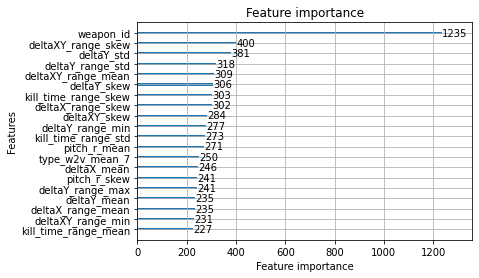

In [31]:
plt.figure(figsize=(16,24))
lgb.plot_importance(clf, max_num_features=20)
plt.show()